In [2]:
import fetcher3 as fetch
import networkx as nx
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import pickle

In [3]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    # nx.draw_networkx_labels(graph,pos)


    plt.savefig(file_name + ".jpg",bbox_inches="tight")
    with open(file_name + ".pickle", 'wb') as handle:
        pickle.dump(graph, handle)
    



100%|██████████| 2000/2000 [11:58<00:00,  2.78it/s]


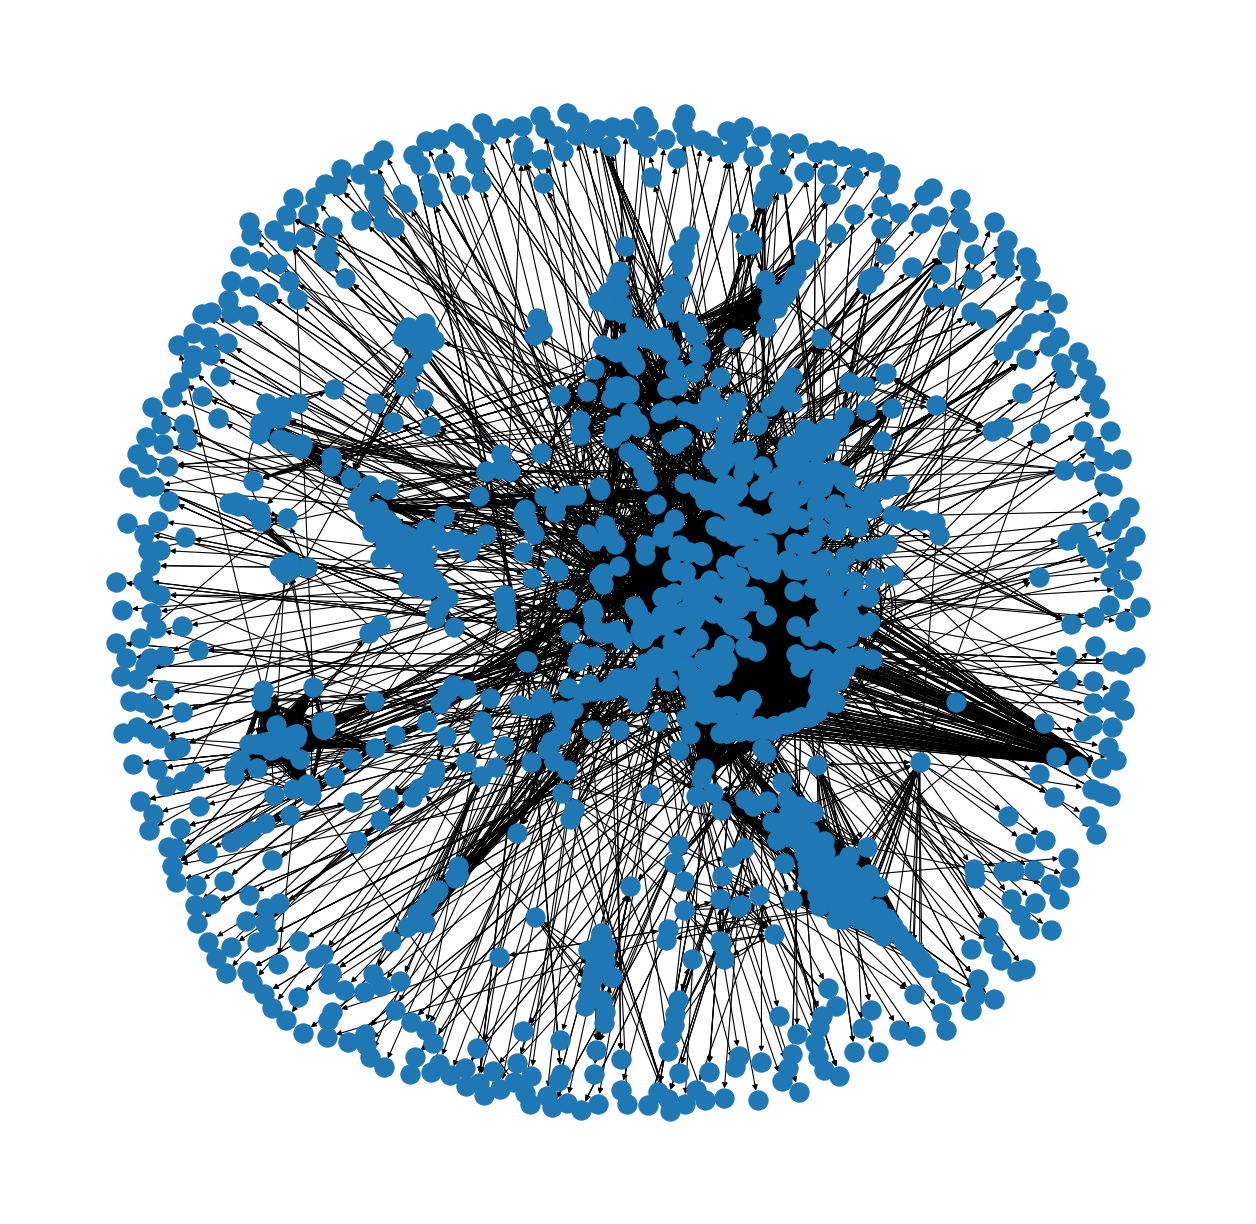

In [8]:
# Does not do the "only add ones you crawl"
stack = [("", "https://www.caltech.edu/")]
visited = set()
G = nx.DiGraph()
with tqdm(total=2000) as pbar:
    while stack and G.number_of_nodes() < 2000:
        parent, url = stack.pop()
        if url in visited:
            if parent:
                G.add_edge(parent, url)
            continue
        visited.add(url)
        G.add_node(url)
        pbar.update(1)
        if parent:
            G.add_edge(parent, url)
        links = fetch.fetch_links(url)
        if not links:
            continue
        links = list(filter(lambda x: "caltech.edu" in x, links))
        edges = [(url, link) for link in links]
        stack.extend(edges)
        
        # print("num_nodes: {}".format(G.number_of_nodes()))
        # time.sleep(0.5)

save_graph(G,"web_graph_full")

The selection policy is primarily whether the domain is caltech.edu. Besides that, I make sure I don't re-crawl already visited nodes, but if a node I visited shows up again I will add the theoretical new edge, since if I'm seeing a node again it's because it's from a parent that links to it that did not exist before, so the edge is new. If a node does not have any links, it's a leaf and I continue.

Advantages: Simple, keeps us within the caltech domain for the most part (aside from edge cases of a query having caltech.edu within it which shouldn't really happen?)

Disadvantages: Sees plenty of useless pages, keeps revisiting certain pages (division home pages, actual home page, etc.), does not properly filter out dynamic pages (there are enough other pages it's not a problem with only 2000 nodes). It also does not deal with http vs https and caltech.edu vs caltech.edu/ and similar cases.

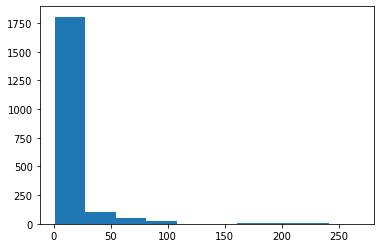

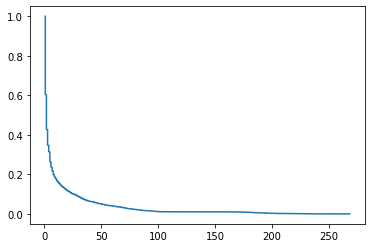

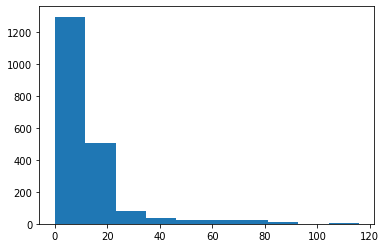

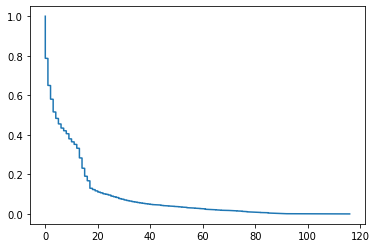

In [12]:
def plot_in_degree_dist(G):
    in_degrees = np.array([G.in_degree(n) for n in G.nodes()])
    plt.hist(in_degrees)
    plt.show()

    x = np.concatenate([np.sort(list(in_degrees))])
    plt.plot(x, np.linspace(1, 0, len(x)))
    plt.show()

def plot_out_degree_dist(G):
    out_degrees = np.array([G.out_degree(n) for n in G.nodes()])
    plt.hist(out_degrees)
    plt.show()

    # cdf = out_degrees.cumsum() / out_degrees.sum()
    # ccdf = 1 - cdf
    # plt.plot(range(len(out_degrees)), ccdf)
    # plt.show()
    x = np.concatenate([np.sort(list(out_degrees))])
    plt.plot(x, np.linspace(1, 0, len(x)))
    plt.show()

plot_in_degree_dist(G)
plot_out_degree_dist(G)


In [10]:
undirected_G = G.to_undirected()
avg_cluster = nx.average_clustering(undirected_G)
overall_cluster = nx.transitivity(undirected_G)

print("avg clustering coeff: {}\n overall clustering coeff: {}".format(avg_cluster, overall_cluster))

avg clustering coeff: 0.4666830625426355
 overall clustering coeff: 0.5191001325426614


In [11]:
max_diameter = nx.diameter(undirected_G)
avg_diameter = nx.average_shortest_path_length(undirected_G)

print("avg diameter: {}\n max diameter: {}".format(avg_diameter, max_diameter))


avg diameter: 5.6658024012006
 max diameter: 18


My clustering coefficients are pretty similar to problem 2's in that both graphs are very highly clustered, but mine is slightly less so. The average and max diameters are  also extremely similar. Both graphs definitely have a large component, and ahve small diameters. They also definitely have high clustering coefficients and are heavy tailed.